# Eye Image Processing

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def find_eye_position(eye):
    '''Finds an eye position
    
    Parameters:
    eye: a OpenCV-based NumPy array of the eye image
    
    Returns:
    (upper_coefs, lower_coefs): a tuple of tuples containing the
    polynomial-fitted coefficients for upper and power eyelids
    respectively
    '''
    chan_diff = (eye[:, :, 2] - eye[:, :, 0]) * 3
    _, chan_th = cv2.threshold(chan_diff, 100, 255, cv2.THRESH_BINARY)
    chan_th = cv2.blur(chan_th, (6, 6))
    _, chan_th = cv2.threshold(chan_th, 100, 255, cv2.THRESH_BINARY)

    xt = np.arange(0, chan_th.shape[1])
    yt = np.argmin(chan_th, axis=0)
    upper_data_points = np.vstack([xt, yt]).T
    upper_data_points = upper_data_points[upper_data_points[:, 1] != 0]

    reversed_chan_th = chan_th[::-1, :]
    xb = np.arange(0, reversed_chan_th.shape[1])
    yb = chan_th.shape[0] - np.argmin(reversed_chan_th, axis=0)
    lower_data_points = np.vstack([xb, yb]).T
    lower_data_points = lower_data_points[lower_data_points[:, 1] != chan_th.shape[0]]

    at, bt, ct = np.polyfit(upper_data_points[:, 0], upper_data_points[:, 1], deg=2)
    ab, bb, cb = np.polyfit(lower_data_points[:, 0], lower_data_points[:, 1], deg=2)
    return ((at, bt, ct), (ab, bb, cb))

def solve_second_degree(a, b):
    '''Solves a second degree polynomial
    
    Parameters:
    a (tuple): The first polynomial coefficients of the form
    a[0](x**2) + a[1](x) + a[2]x
    b (tuple): The second polynomial coefficients of the form
    b[0](x**2) + b[1](x) + b[2]x
    '''
    at, bt, ct = a
    ab, bb, cb = b
    a = at - ab
    b = bt - bb
    c = ct - cb
    x1 = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)
    x2 = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    return x1, x2

We firstly load the image and crop out eyebrow regions

For referencing:
* `76.png`, `207.png` is a good closing eye image
* `100.png`, `123.png` is a good opening eye image

In [4]:
filename = "eyes/brio/35.png"

In [5]:
eye = cv2.imread(filename)
img_length = eye.shape[0]
eye = eye[round(img_length*0.2):round(img_length*0.8), :]
rgb_eye = cv2.cvtColor(eye, cv2.COLOR_BGR2RGB)

In [13]:
upper_eyelid, lower_eyelid = find_eye_position(eye)
left_lim, right_lim = solve_second_degree(upper_eyelid, lower_eyelid)
top_lim, buttom_lim = zero_derivative(upper_eyelid), zero_derivative(lower_eyelid)

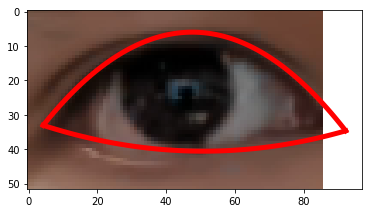

In [18]:
plt.imshow(rgb_eye)
x = np.linspace(left_lim, right_lim, 100)
upper_eyelid_points = np.poly1d(upper_eyelid)(x)
lower_eyelid_points = np.poly1d(lower_eyelid)(x)
plt.plot(x, upper_eyelid_points, linewidth=5, c="red")
plt.plot(x, lower_eyelid_points, linewidth=5, c="red")
plt.show()

In [34]:
def saveeyeimage(filename, output_filename):
    eye = cv2.imread(filename)
    img_length = eye.shape[0]
    eye = eye[round(img_length*0.2):round(img_length*0.8), :]
    rgb_eye = cv2.cvtColor(eye, cv2.COLOR_BGR2RGB)
    upper_eyelid, lower_eyelid = find_eye_position(eye)
    left_lim, right_lim = solve_second_degree(upper_eyelid, lower_eyelid)
    top_lim, buttom_lim = zero_derivative(upper_eyelid), zero_derivative(lower_eyelid)
    x = np.linspace(left_lim, right_lim, 100)
    upper_eyelid_points = np.poly1d(upper_eyelid)(x)
    lower_eyelid_points = np.poly1d(lower_eyelid)(x)
    plt.clf()
    plt.imshow(rgb_eye)
    plt.plot(x, upper_eyelid_points, linewidth=5, c="red")
    plt.plot(x, lower_eyelid_points, linewidth=5, c="red")
    plt.savefig("{}".format(output_filename))

In [28]:
import os

directory = "eyes/brio/"
files = os.listdir(directory)

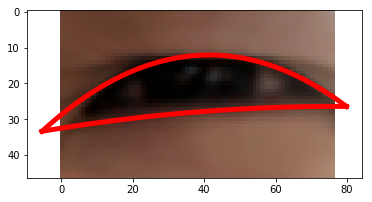

In [35]:
for i in files:
    filename = directory + i
    saveeyeimage(filename, "outputs/"+filename)